In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import networkx as nx

______________________________

In [24]:
network = 'tarbase'

lca_source = 'mirgenedb'  # Options: 'mirgenedb' or 'ensembl'

remove_SSD_pre_2R = False
keep_SSD_pre_2R = False

if remove_SSD_pre_2R and keep_SSD_pre_2R:
	raise ValueError("Cannot both remove and keep pre-2R SSD pairs. Choose one option or remove both.")

if remove_SSD_pre_2R:
	s = 'post_2R'
elif keep_SSD_pre_2R:
	s = 'pre_2R'
else:
	s = ''

remove_large_fam = False
if remove_large_fam:
	max_n_nodes = 8
	s += f'cc_largerthan{str(max_n_nodes)}_removed'

remove_undistinguished_pairs = True
if remove_undistinguished_pairs:
	s += '_undistinguished_pairs_removed'


print("ID string:", s)

ID string: _undistinguished_pairs_removed


In [25]:
file_path_1 = f'./output/{network}_om.z_1000.tsv'
file_path_2 = f'./output/{network}_pm.z_1000.tsv'

df_1 = pd.read_csv(file_path_1, sep='\t', header=0)
df_2 = pd.read_csv(file_path_2, sep='\t', header=0)

In [26]:
ensembl_mirna_pair_lca_file_path = '../../3_retrieve_Hsa_paralogs/all_hsa_ensembl_paralogmirna_clean.tsv'
df_mirna_pair_lca = pd.read_csv(ensembl_mirna_pair_lca_file_path, sep='\t', header=None)
ensembl_pair_lca_dict = {}
for _, row in df_mirna_pair_lca.iterrows():
	ensembl_pair_lca_dict[(row[1], row[3])] = row[4]
	ensembl_pair_lca_dict[(row[3], row[1])] = row[4]

In [27]:
mirna_origin_file_path = '../../MirGeneDB_miRNA_origin/hsa_mirgenedb3.0_to_everything.mirna_origin.tsv'
df_mirgenedb_mirna_origin = pd.read_csv(mirna_origin_file_path, sep='\t', header=None)
# keep only columns 8,14,15 and remove duplicates
df_mirgenedb_mirna_origin = df_mirgenedb_mirna_origin[[8, 14, 15]]
df_mirgenedb_mirna_origin = df_mirgenedb_mirna_origin.drop_duplicates()
cols = ["miRNA", "locus_node_of_origin", "family_node_of_origin"]
df_mirgenedb_mirna_origin.columns = cols
df_mirgenedb_mirna_origin

mirna_lno_dict = {}
for index, row in df_mirgenedb_mirna_origin.iterrows():
	mirna = row['miRNA']
	lno = row['family_node_of_origin']
	if mirna not in mirna_lno_dict:
		mirna_lno_dict[mirna] = []
	mirna_lno_dict[mirna].append(lno)

In [28]:
ordered_lca = {
	'Eumetazoa': 0,
	'Bilateria': 1,
	'Nephrozoa': 2,
	'Chordata': 3,
	'Olfactores': 4,
	'Vertebrata': 5,
	'Gnathostomata': 6,
	'Osteichthyes': 7,
	'Euteleostomi': 8,
	'Sarcopterygii': 9,
	'Tetrapoda': 10,
	'Amniota': 11,
	'Mammalia': 12,
	'Theria': 13,
	'Eutheria': 14,
	'Boroeutheria': 15,
	'Euarchontoglires': 16,
	'Primates': 17,
	'Simiiformes': 18,
	'Catarrhini': 19,
	'Hominidae': 20,
	'Homo_sapiens': 21
}

reverted_ordered_lca_dict = {v: k for k, v in ordered_lca.items()}

In [29]:
df_wgd = df_1
df_ssd = df_2

In [30]:
if remove_undistinguished_pairs:
	df_wgd = df_wgd[~((df_wgd['n_common_targets'] == df_wgd['n_tar_1']) & (df_wgd['n_common_targets'] == df_wgd['n_tar_2']))]
	df_ssd = df_ssd[~((df_ssd['n_common_targets'] == df_ssd['n_tar_1']) & (df_ssd['n_common_targets'] == df_ssd['n_tar_2']))]

In [31]:
def add_ensembl_lca(df, dict):
    df_cp = df.copy()
    df_cp['lca'] = df_cp.apply(lambda row: dict.get((row['miRNA_1'], row['miRNA_2'])), axis=1)
    return df_cp

def add_mirgenedb_lca(df, single_miRNA_dict, dict):
	reverted_dict = {v: k for k, v in dict.items()}
	def compute_max_lca(miRNA):
		# If the miRNA value itself is NaN/null, skip immediately
		if pd.isna(miRNA):
			return -1
		# Look up its list of lno’s; if that’s not a list/tuple, treat as empty
		lno_list = single_miRNA_dict.get(miRNA, [])
		if not isinstance(lno_list, (list, tuple)):
			return -1
		# Map to ordered_lca values and take the max (or -1 if empty)
		return max((dict.get(lno, -1) for lno in lno_list), default=-1)
    
	df_cp = df.copy()
	df_cp['lca_1'] = df_cp['miRNA_1'].apply(compute_max_lca)
	df_cp['lca_2'] = df_cp['miRNA_2'].apply(compute_max_lca)
	df_cp['lca_code'] = df_cp[['lca_1', 'lca_2']].max(axis=1)
	df_cp = df_cp.drop(columns=['lca_1', 'lca_2'])
	df_cp['lca'] = df_cp['lca_code'].apply(
		lambda code: reverted_dict.get(code, 'Unknown')
	)
	df_cp = df_cp.drop(columns=['lca_code'])
	return df_cp

if lca_source == "ensembl":
    print("Using Ensembl for LCA")
    df_wgd_lca = add_ensembl_lca(df_wgd, ensembl_pair_lca_dict)
    df_ssd_lca = add_ensembl_lca(df_ssd, ensembl_pair_lca_dict)
elif lca_source == "mirgenedb":
    print("Using MirGeneDB for LCA")
    df_wgd_lca = add_mirgenedb_lca(df_wgd, mirna_lno_dict, reverted_ordered_lca_dict)
    df_ssd_lca = add_mirgenedb_lca(df_ssd, mirna_lno_dict, reverted_ordered_lca_dict)
else:
    raise ValueError(f"{lca_source} is an invalid LCA source. Using MirGeneDB.")


Using MirGeneDB for LCA


In [32]:
df_wgd_lca[df_wgd_lca['lca']=='None']

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_vmotif,n_maj_true,Z-score,pValue (nm size=1000),lca


In [33]:
print("Number of WGD pairs: ", len(df_wgd_lca))
print("Number of SSD pairs: ", len(df_ssd_lca))

Number of WGD pairs:  101
Number of SSD pairs:  507


In [34]:
pre_2R_clades = ['Bilateria', 'Chordata', 'Eumetazoa', 'Vertebrata', 'Nephrozoa', 'Olphactores']

if remove_SSD_pre_2R:
	df_ssd_lca = df_ssd_lca[~df_ssd_lca['lca'].isin(pre_2R_clades)]
if keep_SSD_pre_2R:
	df_ssd_lca = df_ssd_lca[df_ssd_lca['lca'].isin(pre_2R_clades)]

print("Number of WGD pairs: ", len(df_wgd_lca))
print("Number of SSD pairs: ", len(df_ssd_lca))

Number of WGD pairs:  101
Number of SSD pairs:  507


In [35]:
def remove_large_cc(df, max_size):
    df['Z-score'] = pd.to_numeric(df['Z-score'], errors='coerce')
    G = nx.Graph()
    for _, row in df.iterrows():
        G.add_edge(row['miRNA_1'], row['miRNA_2'])

    # Identify connected components
    large_components = [comp for comp in nx.connected_components(G) if len(comp) > max_size]

    if not large_components:
        return df

    # Process each large component separately
    indices_to_keep = set()

    for comp in large_components:
        comp_df = df[(df['miRNA_1'].isin(comp)) & (df['miRNA_2'].isin(comp))]
        top_pairs = comp_df.nlargest(max_size, 'Z-score')
        #indices_to_keep.update(top_pairs.index)

    # Identify edges to retain from small components
    small_components = [comp for comp in nx.connected_components(G) if len(comp) <= max_size]
    for comp in small_components:
        comp_df = df[(df['miRNA_1'].isin(comp)) & (df['miRNA_2'].isin(comp))]
        indices_to_keep.update(comp_df.index)

    return df.loc[sorted(indices_to_keep)].reset_index(drop=True)

In [36]:
def remove_mirna_pairs(df1, df2):
	"""
	Removes from df1 all rows whose (miRNA_1, miRNA_2) pairs (regardless of order)
	are present in df2.
	"""
	# Create a set of tuples for the miRNA pairs in df2
	mirna_pairs = set()
	for _, row in df2.iterrows():
		mirna1 = row['miRNA_1']
		mirna2 = row['miRNA_2']
		if mirna1 != mirna2:
			mirna_pairs.add(tuple(sorted([mirna1, mirna2])))

	# Filter df1 to remove rows with miRNA pairs present in df2
	filtered_df = df1[~df1.apply(lambda row: tuple(sorted([row['miRNA_1'], row['miRNA_2']])) in mirna_pairs, axis=1)]
	
	return filtered_df


df_ssd_lca = remove_mirna_pairs(df_ssd_lca, df_wgd_lca)

print("Number of WGD pairs after removing miRNA pairs from SSD: ", len(df_wgd_lca))
print("Number of SSD pairs after removing miRNA pairs from SSD: ", len(df_ssd_lca))

Number of WGD pairs after removing miRNA pairs from SSD:  101
Number of SSD pairs after removing miRNA pairs from SSD:  438


In [37]:
def remove_sigma_err(df):
    # Step 1: Set Z-score to 0 if Z-score == 'sigma_err' and n_vmotif == 0
    mask_fix = (df['Z-score'] == 'sigma_err') & (df['n_vmotif'] == 0)
    df.loc[mask_fix, 'Z-score'] = 0

    # Step 2: Remove rows where Z-score == 'sigma_err' and n_vmotif != 0
    mask_remove = (df['Z-score'] == 'sigma_err') & (df['n_vmotif'] != 0)
    df = df[~mask_remove]

    return df

if remove_large_fam:
	max_n_nodes = 4
	df_ssd_lca_parsed = remove_large_cc(remove_sigma_err(df_ssd_lca), max_n_nodes)
	df_wgd_lca_parsed = remove_large_cc(remove_sigma_err(df_wgd_lca), max_n_nodes)
else:
	df_ssd_lca_parsed = remove_sigma_err(df_ssd_lca)
	df_wgd_lca_parsed = remove_sigma_err(df_wgd_lca)

In [38]:
df_wgd_lca_zscores = df_wgd_lca_parsed['Z-score'].astype(float)
df_ssd_lca_zscores = df_ssd_lca_parsed['Z-score'].astype(float)

df_wgd_lca_nbifan = df_wgd_lca_parsed['n_vmotif'].astype(int)
df_ssd_lca_nbifan = df_ssd_lca_parsed['n_vmotif'].astype(int)

In [39]:
n_wgd = len(df_wgd_lca_zscores)
n_ssd = len(df_ssd_lca_zscores)

print("n_wgd in the boxplot: ", n_wgd)
print("n_ssd in the boxplot: ", n_ssd)

n_wgd in the boxplot:  101
n_ssd in the boxplot:  438


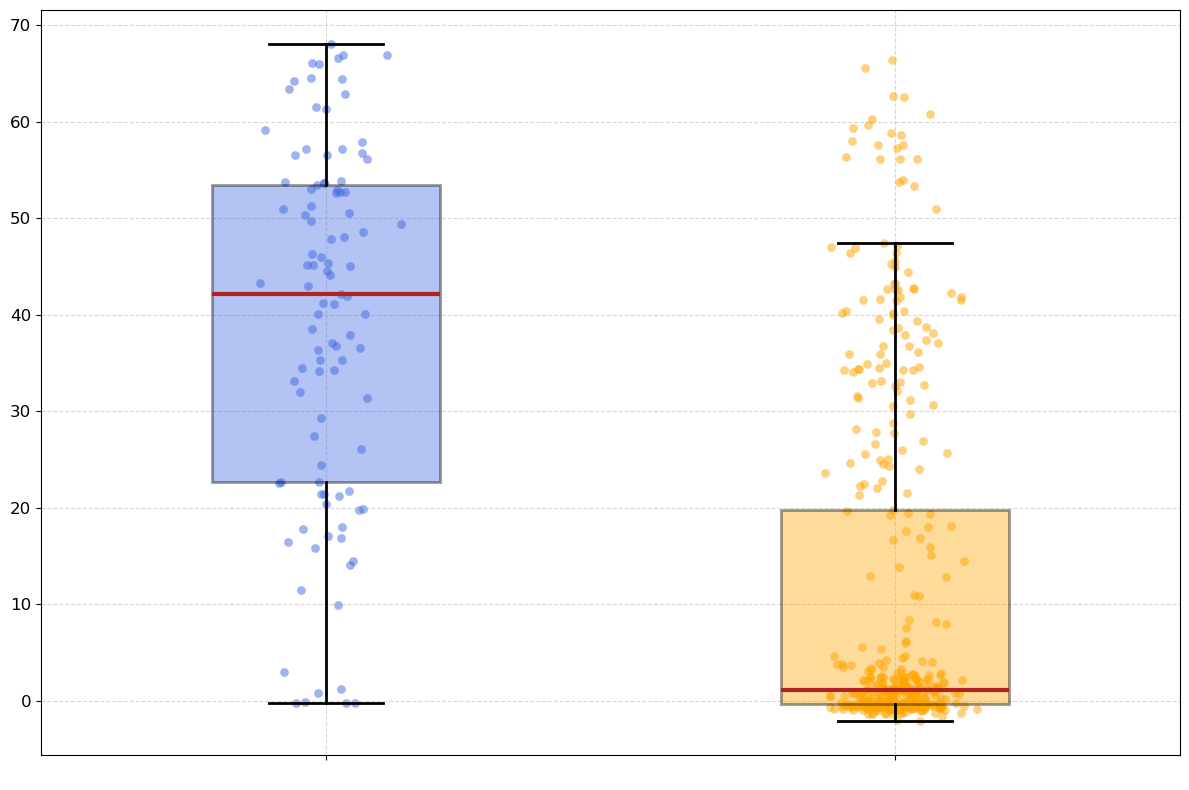

Number of WGD pairs: 101
Number of SSD pairs: 438


In [40]:
data = [df_wgd_lca_zscores, df_ssd_lca_zscores]
positions = [0, 1]
colors = ['royalblue', 'orange']

plt.figure(figsize=(12, 8))

box = plt.boxplot(data, 
                  positions=positions, 
                  widths=0.4,
                  patch_artist=True, 
                  showfliers=False)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(2)
    patch.set_alpha(0.4)
    
for element in ['whiskers', 'caps']:
    for line in box[element]:
        line.set_linewidth(2)
        line.set_color('black')
        
for element in ['medians']:
    for line in box[element]:
        line.set_linewidth(3)
        line.set_color('firebrick')

for i, (scores, color) in enumerate(zip(data, colors)):
    jittered_x = np.random.normal(loc=positions[i], scale=0.05, size=len(scores))
    plt.scatter(jittered_x, scores, alpha=0.5, color=color, linewidth=0.2, label=['', ''][i])

plt.xticks(positions, [' ', ' '], fontsize=100)
#plt.ylim(-3, 40)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig(f'../../local/pictures/ensembl_vmotif_zscores_boxplot_{s}.jpg', bbox_inches='tight')
plt.show()

print(f"Number of WGD pairs: {len(df_wgd_lca_parsed)}")
print(f"Number of SSD pairs: {len(df_ssd_lca_parsed)}")

In [41]:
ks_stat, ks_p_value = stats.ks_2samp(df_wgd_lca_zscores, df_ssd_lca_zscores)
print(f"KS test results with parameters:\nnetwork={network}\nremove_pre_2R={remove_SSD_pre_2R}")
print(75 * "=")
print(f"KS statistic: {ks_stat}, p-value: {ks_p_value}")

KS test results with parameters:
network=tarbase
remove_pre_2R=False
KS statistic: 0.6407387314073874, p-value: 1.0905043221482581e-32


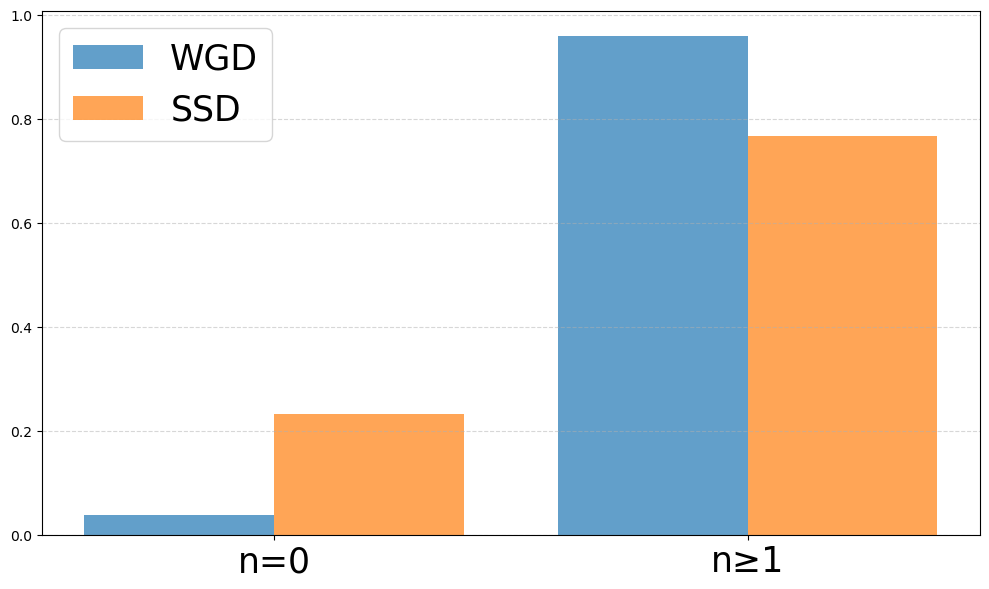

In [44]:
labels = ['n=0', 'n≥1']

def bin_bifans(count, labels=labels):
    if count == 0:
        return labels[0]
    else:
        return labels[1]

# Bin the counts
wgd_binned = pd.Series(df_wgd_lca_nbifan).apply(bin_bifans)
ssd_binned = pd.Series(df_ssd_lca_nbifan).apply(bin_bifans)

# Get relative frequencies for each bin
wgd_freq = wgd_binned.value_counts(normalize=True).reindex(labels, fill_value=0)
ssd_freq = ssd_binned.value_counts(normalize=True).reindex(labels, fill_value=0)

x = np.arange(len(labels))
width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, wgd_freq, width=width, label='WGD', alpha=0.7)
plt.bar(x + width/2, ssd_freq, width=width, label='SSD', alpha=0.7)

plt.xticks(x, labels, fontsize=25)
plt.xlabel('')
plt.title('')
plt.legend(fontsize=25)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(f'../../local/pictures/ensembl_vmotif_nmotif_barplot_{s}.jpg', bbox_inches='tight')
plt.show()

________________________________________

## Subgenome analysis

In [87]:
subg_file = '../../1.1_retrieve_Hsa_ohnomirnas/gnathostomata_ohnolog_reference_singlecol.gene.tsv'
df_subg = pd.read_csv(subg_file, sep='\t', header=None)
cols = ['miRNA', 'subgenome', 'CLG']
df_subg.columns = cols
df_subg

def label_subgenome(df_dup, df_subg, prefix):
    # Create a dictionary from df_subg (miRNA -> subgenome)
    subg_dict = dict(zip(df_subg['miRNA'], df_subg['subgenome']))

    # Function to translate and label each miRNA
    def translate_miRNA(miRNA):
        miRNA_clean = miRNA.replace(prefix, "")
        return subg_dict.get(miRNA_clean, 'unknown')

    # Apply subgenome labels
    df_dup_cp = df_dup.copy()
    df_dup_cp['subg_1'] = df_dup_cp['miRNA_1'].apply(translate_miRNA)
    df_dup_cp['subg_2'] = df_dup_cp['miRNA_2'].apply(translate_miRNA)

    # Split into numeric and Greek part
    df_dup_cp['miRNA_1_1R'] = df_dup_cp['subg_1'].str.extract(r'(\d)')
    df_dup_cp['miRNA_1_2R'] = df_dup_cp['subg_1'].str.extract(r'(alpha|beta)')

    df_dup_cp['miRNA_2_1R'] = df_dup_cp['subg_2'].str.extract(r'(\d)')
    df_dup_cp['miRNA_2_2R'] = df_dup_cp['subg_2'].str.extract(r'(alpha|beta)')

    return df_dup_cp

df_wgd_lca_parsed_subg = label_subgenome(df_wgd_lca_parsed, df_subg, '')

n_1 =  32
n_2 =  33
n_3 =  27
n_4 =  9


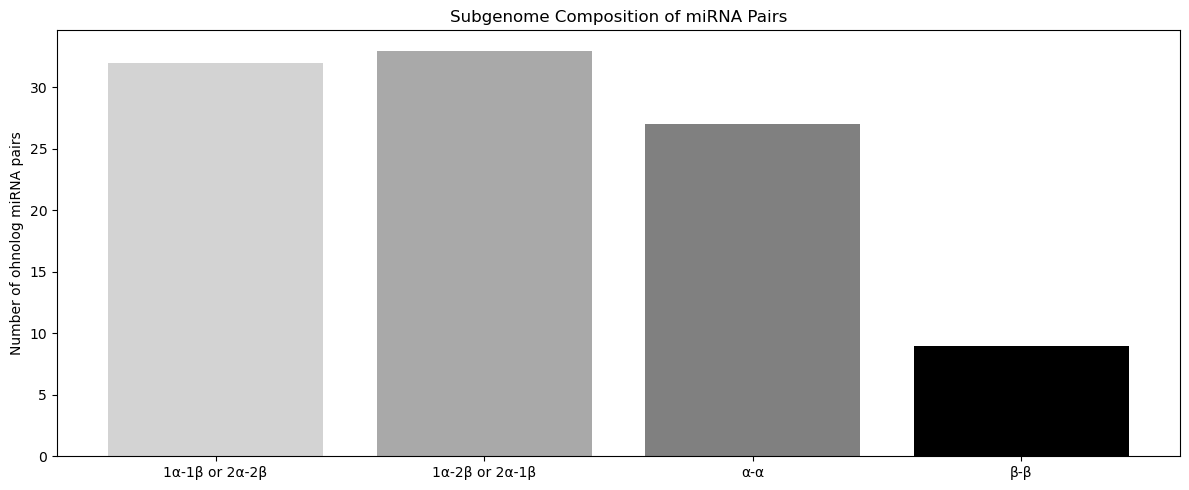

In [88]:
mask_1 = (
    ((df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'alpha') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'beta') & (df_wgd_lca_parsed_subg['miRNA_1_1R'] == df_wgd_lca_parsed_subg['miRNA_2_1R'])) |
    ((df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'beta') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'alpha') & (df_wgd_lca_parsed_subg['miRNA_1_1R'] == df_wgd_lca_parsed_subg['miRNA_2_1R']))
)

mask_2 = (
    ((df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'alpha') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'beta') & (df_wgd_lca_parsed_subg['miRNA_1_1R'] != df_wgd_lca_parsed_subg['miRNA_2_1R'])) |
    ((df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'beta') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'alpha') & (df_wgd_lca_parsed_subg['miRNA_1_1R'] != df_wgd_lca_parsed_subg['miRNA_2_1R']))
)

mask_3 = (
	(df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'alpha') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'alpha') 
)

mask_4 = (
	(df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'beta') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'beta') 
)

# add a column named "dup_subgenome_type" with "A" if mask_1 is True, "B" if mask_2 is True, and "C" if mask_3 is True
df_wgd_lca_parsed_subg['dup_subgenome_type'] = np.select(
	[mask_1, mask_2, mask_3, mask_4],
	['A', 'B', 'C', 'D']
)

n_1 = df_wgd_lca_parsed_subg[mask_1].shape[0]
n_2 = df_wgd_lca_parsed_subg[mask_2].shape[0]
n_3= df_wgd_lca_parsed_subg[mask_3].shape[0]
n_4 = df_wgd_lca_parsed_subg[mask_4].shape[0]

print("n_1 = ", n_1)
print("n_2 = ", n_2)
print("n_3 = ", n_3)
print("n_4 = ", n_4)

# Plot
plt.figure(figsize=(12, 5))
plt.bar(['1α-1β or 2α-2β', '1α-2β or 2α-1β', 'α-α', 'β-β'], [n_1, n_2, n_3, n_4], color=['lightgrey', 'darkgrey', 'grey', 'black'])
plt.ylabel('Number of ohnolog miRNA pairs')
plt.title('Subgenome Composition of miRNA Pairs')
plt.tight_layout()
plt.savefig(f'../../local/pictures/vmotif_subgenome_numbers_{s}.jpg', bbox_inches='tight')
plt.show()

In [89]:
df_wgd_lca_parsed_subg.head(60)

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_vmotif,n_maj_true,Z-score,pValue (nm size=1000),lca,subg_1,subg_2,miRNA_1_1R,miRNA_1_2R,miRNA_2_1R,miRNA_2_2R,dup_subgenome_type
0,MIR101-1,MIR101-2,190,159,159,7.334,2.472740,159,0,61.335195,0.000000,Unknown,1alpha,2alpha,1,alpha,2,alpha,C
1,MIR103A1,MIR103A2,950,1075,950,192.885,11.318117,950,0,66.894077,0.000000,Unknown,2beta,2alpha,2,beta,2,alpha,A
2,MIR103A1,MIR107,950,959,927,174.186,11.057640,927,0,68.080892,0.000000,Unknown,2beta,1alpha,2,beta,1,alpha,B
3,MIR103A2,MIR107,1075,959,930,193.784,11.455625,930,0,64.266769,0.000000,Unknown,2alpha,1alpha,2,alpha,1,alpha,C
4,MIR106A,MIR106B,538,398,205,46.433,6.068403,205,0,26.129940,0.000000,Unknown,1beta,2beta,1,beta,2,beta,D
5,MIR106A,MIR17,538,1373,308,141.790,9.825981,308,0,16.915360,0.000000,Unknown,1beta,1alpha,1,beta,1,alpha,A
6,MIR106B,MIR17,398,1373,238,106.357,8.296840,238,0,15.866644,0.000000,Unknown,2beta,1alpha,2,beta,1,alpha,B
7,MIR10A,MIR10B,272,141,49,9.224,2.821670,49,0,14.096614,0.000000,Unknown,1beta,2alpha,1,beta,2,alpha,B
11,MIR125A,MIR125B1,306,270,229,19.214,3.983491,229,0,52.663851,0.000000,Unknown,1alpha,1beta,1,alpha,1,beta,A
12,MIR125A,MIR125B2,306,367,233,25.532,4.701168,233,0,44.131165,0.000000,Unknown,1alpha,2alpha,1,alpha,2,alpha,C


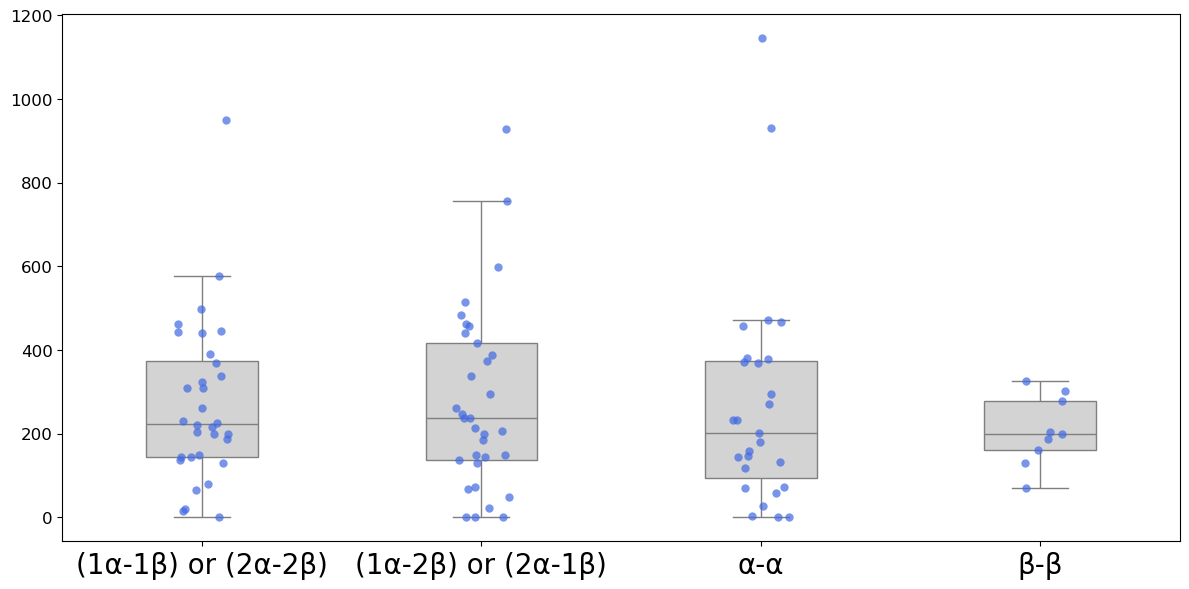

In [60]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='dup_subgenome_type', y='n_vmotif', data=df_wgd_lca_parsed_subg, 
			order=['A', 'B', 'C', 'D'], showfliers=False, width=0.4, linewidth=1, color='lightgrey')
sns.stripplot(x='dup_subgenome_type', y='n_vmotif', data=df_wgd_lca_parsed_subg, 
			order=['A', 'B', 'C', 'D'], color='royalblue', alpha=0.7, s=6, jitter=True)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
v = ['(1α-1β) or (2α-2β)', '(1α-2β) or (2α-1β)', 'α-α', 'β-β']
plt.xticks(ticks=range(len(v)), labels=v, fontsize=12)
plt.title('', fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f'../../local/pictures/vmotif_subgenome_nbifan_{s}.jpg', bbox_inches='tight')
plt.show()

In [61]:
print(df_wgd_lca_parsed_subg['Z-score'].unique())

[61.33519453 66.8940772  68.08089203 64.26676854 26.12994037 16.91535962
 15.86664355 14.09661441 52.66385117 44.13116515 53.66843829 64.48734288
 -0.20676767 -0.20145155 -0.21707238 -0.18181818 52.74329324 37.08786008
 41.91846379 43.28385112 35.31495076 32.0147337  35.26517697 46.01938061
 53.49359833 21.39162586 22.65057145 22.70645861 22.57625068 36.77022425
 65.98995275 33.15400042 17.77086224 34.27415679 16.47205172 29.25313551
 47.84472138 36.56831013 24.47511445 66.10201075 48.05550314 49.38656457
 45.40729409 20.34910971 45.1560617  57.17079409 50.93667227 45.21266198
 59.14880002 64.54605935 53.04829503 36.37214875 51.23740225 21.4642669
 17.99531451 42.13768816 31.35232502 11.48535551 52.95924712 40.09544326
 46.31579412 63.36789416 66.90275537 44.4999312  43.01470613 34.16218594
 41.10929296 53.83753416 48.54082338 66.65376283 57.88023635 56.60272009
 52.7594786  50.59205297 56.51967234 21.24587984 19.76836407  0.80087178
  1.16454674 56.15462554  2.93645075 57.15836327 62.

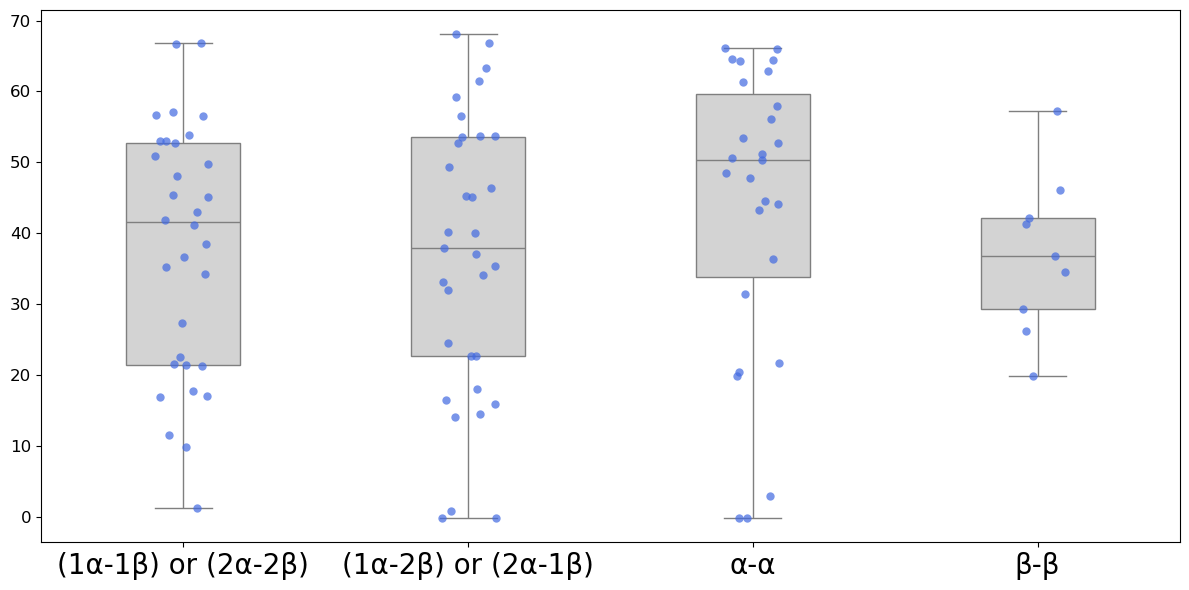

In [62]:
plt.figure(figsize=(12, 6))
df_wgd_lca_parsed_subg['Z-score'] = pd.to_numeric(df_wgd_lca_parsed_subg['Z-score'], errors='coerce')
sns.boxplot(x='dup_subgenome_type', y='Z-score', data=df_wgd_lca_parsed_subg, 
			order=['A', 'B', 'C', 'D'], showfliers=False, width=0.4, linewidth=1, color='lightgrey')
sns.stripplot(x='dup_subgenome_type', y='Z-score', data=df_wgd_lca_parsed_subg, 
			order=['A', 'B', 'C', 'D'], color='royalblue', alpha=0.7, s=6, jitter=True)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
v = ['(1α-1β) or (2α-2β)', '(1α-2β) or (2α-1β)', 'α-α', 'β-β']
plt.xticks(ticks=range(len(v)), labels=v, fontsize=12)
plt.title('', fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f'../../local/pictures/vmotif_subgenome_zscore_{s}.jpg', bbox_inches='tight')
plt.show()

____________________

## Expression

In [63]:
dict_path = '../../1.1_retrieve_Hsa_ohnomirnas/ohnomirna_mgdb_to_gene.dic'

dic = {}
with open(dict_path) as f:
	for line in f:
		parts = line.strip().split('\t')
		if len(parts) == 2:
			dic[parts[1]] = parts[0]

In [64]:
avg_expr_matrix_path = '../../miRNATissueAtlas_expression/all_human_miRNA_rpmm_harmonized_meta_data.mgdb.csv'

with open(avg_expr_matrix_path) as f:
    lines = [line.strip().split('\t') for line in f.readlines()[:4]]
    
columns = list(zip(*lines))
merged_header = ['{},{}'.format(columns[i][0], ','.join(columns[i][1:])) for i in range(len(columns))]
h = '\t'.join(merged_header)

expr_df = pd.read_csv(avg_expr_matrix_path, index_col=None, sep='\t', header=None)
expr_df = expr_df.iloc[4:, :]
expr_df.columns = h.split('\t')
expr_df.set_index(expr_df.columns[0], inplace=True)
expr_df = expr_df[expr_df.index != 'unknown_mirna']
expr_df = expr_df[expr_df.index != 'premirna_not_in_mirgenedb']
expr_df = expr_df.apply(pd.to_numeric)
expr_df = expr_df.loc[:, expr_df.columns.str.endswith('mean')]

expr_df

/tmp/ipykernel_43489/224704369.py:10: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262

,"EV,adipose,adipose,mean","EV,airway,epithelium,mean","EV,airway,pharynx,mean","EV,artery,artery,mean","EV,blood,GDM,mean","EV,blood,Molm14,mean","EV,blood,PBMC,mean","EV,blood,THP,mean","EV,blood,blood,mean","EV,blood,plasma,mean",...,"tissue,tongue,tongue,mean","tissue,tonsil,tonsil,mean","tissue,trachea,trachea,mean","tissue,umbilical_cord,huvec,mean","tissue,umbilical_cord,umbilical_cord,mean","tissue,urethra,urethra,mean","tissue,urine,urine,mean","tissue,uterus,uterus,mean","tissue,vaginal_tissue,vaginal_tissue,mean","tissue,vein,vein,mean"
"Biotype,Organ_system,Tissue,Metric",,,,,,,,,,,,,,,,,,,,,
Hsa-Let-7-P1b,1088.428021,243.546543,0.043313,219.914918,568.125633,194.249264,281.727338,42.597923,137.123529,565.522809,...,1485.267408,1012.027760,2450.948916,2259.509429,1271.972792,2476.532603,467.290950,1236.827140,2437.746786,776.000649
Hsa-Let-7-P1b,6.505383,4.492620,0.000000,47.933493,15.282738,2.515213,0.649421,0.401885,3.789879,3.072286,...,2.586946,5.930494,5.310115,11.823245,10.589435,4.679424,4.812450,6.962467,33.098248,4.027219
Hsa-Let-7-P1c,4.816620,0.000000,0.000000,44.683410,0.308100,12.401268,0.023610,0.000000,1.241202,1.098243,...,3.459201,5.605949,3.207017,11.017460,10.217927,4.434976,2.537118,1.827755,4.520438,1.293623
Hsa-Let-7-P1c,4765.081268,206.162963,0.557305,609.405956,87.788778,1595.478431,91.012267,197.572829,522.647640,1082.661796,...,4764.332005,2030.584158,8786.298873,2077.455856,1362.149626,8060.796190,1114.537047,2994.291358,12096.249358,2990.441585
Hsa-Let-7-P1d,0.582867,0.754825,0.000000,68.443741,0.179697,0.000000,0.000000,0.000000,0.469278,0.381515,...,0.365671,0.565189,1.068588,5.455957,2.780810,0.838106,7.392894,0.204405,1.249168,0.557457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hsa-Mir-96-P2,2.985072,1043.589374,6.907106,47.118951,55.192044,33.070895,151.360592,150.744449,425.107901,529.451015,...,310.940806,8656.767830,377.471680,43.859254,1297.497460,123.201543,182.363125,1748.267031,220.295288,207.660570
Hsa-Mir-96-P3,0.000000,2.507751,0.000000,35.292801,1.349744,0.206051,0.037953,0.025759,1.006019,0.453172,...,12.403298,9.526723,1.988102,0.032581,4.613867,1.466685,1.849835,0.908452,2.879971,0.497193
Hsa-Mir-96-P3,0.747757,842.679437,5.148449,36.157231,34.706521,22.573360,13.384168,96.518346,150.865892,346.188089,...,219.570064,593.713919,112.203670,4.740391,437.259549,43.511656,77.749900,174.234731,93.439187,60.275389
